# Tuning Machine Learning models in Spark

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

## ML Pipelines in Spark

ML model training and tuning often represents running the same steps once and again. Often, we run the same steps with small variations in order to evaluate combinations of parameters. 

In order to make this use case a lot easier, Spark provides the [Pipeline](https://spark.apache.org/docs/2.2.0/ml-pipeline.html) abstraction.

A Pipeline represents a series of steps in the processing of a dataset. Each step is a Transformer or an Estimator. The whole Pipeline is an Estimator, so we can .fit the whole pipeline in one step. When we do that, the steps'  .fit and .transform methods will be called in turn.

![pipelineestimator](https://spark.apache.org/docs/2.3.0/img/ml-Pipeline.png)

![PipelineModel](https://spark.apache.org/docs/2.3.0/img/ml-PipelineModel.png)

## Example: predicting flight delays

We'll be using the same [Transtats'](https://www.transtats.bts.gov/) OTP performance data] from way back when. Remember it?

It's a table that contains all domestic departures by US air air carriers that represent at least one percent of domestic scheduled passenger revenues, with data on each individual departure including [Tail Number](https://en.wikipedia.org/wiki/Tail_number), departure delay, origin, destination and carrier.


### Load the data

Opening .zip files in Spark is a bit of a pain. For now, let's just decompress the file we want to read. When we are ready to expand the processing to the cluster, we will need to do [this](https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark):

```python
from pyspark.sql import SparkSession, types, functions
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

path_to_file = '/home/dani/repos/master-data-science/data/us_dot/otp/On_Time_On_Time_Performance_2015_8.zip'
csv_filename = 'On_Time_On_Time_Performance_2015_8.csv'

!unzip -o {path_to_file} {csv_filename} -d .

columns_of_interest =['FlightDate', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 
                      'Carrier', 'TailNum', 'FlightNum', 'Origin', 'OriginCityName',
                      'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                      'DepTime', 'DepDelay', 'Distance']

```

In [1]:
from pyspark.sql import SparkSession, types, functions
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

path_to_file = '/home/dani/repos/master-data-science/data/us_dot/otp/On_Time_On_Time_Performance_2015_8.zip'
csv_filename = 'On_Time_On_Time_Performance_2015_8.csv'

!unzip -o {path_to_file} {csv_filename} -d .

columns_of_interest =['FlightDate', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 
                      'Carrier', 'TailNum', 'FlightNum', 'Origin', 'OriginCityName',
                      'OriginStateName', 'Dest', 'DestCityName', 'DestStateName',
                      'DepTime', 'DepDelay', 'Distance']

Archive:  /home/dani/repos/master-data-science/data/us_dot/otp/On_Time_On_Time_Performance_2015_8.zip
  inflating: ./On_Time_On_Time_Performance_2015_8.csv  


In [3]:
!head -2 On_Time_On_Time_Performance_2015_8.csv

"Year","Quarter","Month","DayofMonth","DayOfWeek","FlightDate","UniqueCarrier","AirlineID","Carrier","TailNum","FlightNum","OriginAirportID","OriginAirportSeqID","OriginCityMarketID","Origin","OriginCityName","OriginState","OriginStateFips","OriginStateName","OriginWac","DestAirportID","DestAirportSeqID","DestCityMarketID","Dest","DestCityName","DestState","DestStateFips","DestStateName","DestWac","CRSDepTime","DepTime","DepDelay","DepDelayMinutes","DepDel15","DepartureDelayGroups","DepTimeBlk","TaxiOut","WheelsOff","WheelsOn","TaxiIn","CRSArrTime","ArrTime","ArrDelay","ArrDelayMinutes","ArrDel15","ArrivalDelayGroups","ArrTimeBlk","Cancelled","CancellationCode","Diverted","CRSElapsedTime","ActualElapsedTime","AirTime","Flights","Distance","DistanceGroup","CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay","FirstDepTime","TotalAddGTime","LongestAddGTime","DivAirportLandings","DivReachedDest","DivActualElapsedTime","DivArrDelay","DivDistance","Div1Airport","Div1A

Our data has been read in with all fields typed as strings. Let's use the inferSchema argument to .read.csv:

In [5]:
session = SparkSession.builder.getOrCreate()
flights = session.read.csv('On_Time_On_Time_Performance_2015_8.csv', inferSchema=True, header=True)
flights

DataFrame[Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, FlightDate: timestamp, UniqueCarrier: string, AirlineID: int, Carrier: string, TailNum: string, FlightNum: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, Origin: string, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, Dest: string, DestCityName: string, DestState: string, DestStateFips: int, DestStateName: string, DestWac: int, CRSDepTime: int, DepTime: int, DepDelay: double, DepDelayMinutes: double, DepDel15: double, DepartureDelayGroups: int, DepTimeBlk: string, TaxiOut: double, WheelsOff: int, WheelsOn: int, TaxiIn: double, CRSArrTime: int, ArrTime: int, ArrDelay: double, ArrDelayMinutes: double, ArrDel15: double, ArrivalDelayGroups: int, ArrTimeBlk: string, Cancelled: double, CancellationCode: string, Diverted: double, CRSElapsedTime: double, ActualE

In [6]:
flights.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: timestamp (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- AirlineID: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DestAirportSeqID: integer (nullable = true)
 |-- DestCityMarketID: integer (nu

In [7]:
simplified = flights.select(columns_of_interest)
simplified

DataFrame[FlightDate: timestamp, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, Distance: double]

### Drop nas

There are only a few departures for which any of the columns of interest contains null values. The most expedient way to handle them is to just drop them, since they won't make much of a difference.

NA-related functions are grouped in a .na attribute of DataFrames.

In [10]:
df = simplified.na.drop()
df

DataFrame[FlightDate: timestamp, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, Distance: double]

## Feature extraction and generation of target variable

The departing hour is the most important factor in delays, so we need to calculate it from the departure time. Since the input file uses a funny format for times, Spark has interpreted them as floats:

In [12]:
df.select('DepTime').show(10)

+-------+
|DepTime|
+-------+
|    854|
|    858|
|    902|
|    857|
|    857|
|    854|
|    854|
|    850|
|   1023|
|    853|
+-------+
only showing top 10 rows



#### Exercise

Calculate the 'DepHour' column that represents the hour as an int.

In [21]:
from pyspark.sql import types

df = df.withColumn('DepHour', (df['DepTime'] / 100).cast(types.IntegerType()))
df

DataFrame[FlightDate: timestamp, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, Distance: double, DepHour: int]

We will also generate a binary target variable. The aviation industry considers a flight delayed when it departs more than 15 minutes after its scheduled departure time, so we will use that. We will create it as an integer, since that is what the learning algorithms expect.

In [24]:
df2 = df.withColumn('Delayed', (df['DepDelay'] > 15).cast(types.IntegerType()))
df2

DataFrame[FlightDate: timestamp, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, Distance: double, DepHour: int, Delayed: int]

In order to make the training times manageable, let's pick only 10% of the data to train.

In [26]:
sample, rest = df2.randomSplit([1., 9.])

## Handle different fields in different ways

We have features of at least three kinds:

* Numeric continuous fields, which we can use as input to many algorithms as they are. In particular, decision trees can take continuous variables with any value as input, since they only look for the cutoff point that most increases the homogeneity of the resulting groups. In contrast, if we were using a logistic regression with regularization, for example, we would need to first scale the variables to have comparable magnitudes.

* There are fields which we will treat as categorical variables, but which are already integers. These need to be one-hot encoded.

* Finally, there are several categorical variables that are encoded as strings. These need to be one-hot encoded, but OneHotEncoder requires numeric input. Therefore, we will need to apply a StringIndexer to each of them before one-hot encoding.

In [31]:
sample.schema.fields[0].dataType

TimestampType

In [32]:
categorical_fields = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier', 
                      'Origin', 'OriginCityName', 'OriginStateName', 
                      'Dest', 'DestCityName', 'DestStateName']

string_fields = [ field.name for field in sample.schema.fields if field.dataType == types.StringType()]

continuous_fields = ['Distance', 'DepHour']

target_field = 'Delayed'

In [33]:
string_fields

['Carrier',
 'TailNum',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

We have generated the list of names of columns that have dataType string with a list comprehension, rather than hard-coding it, but it is just like the other ones.

## Handling categorical fields

Let's do the processing of just one field first, as an example. Then we will process the rest.

### StringIndexer 

A [StringIndexer](https://spark.apache.org/docs/2.2.0/ml-features.html#stringindexer) is an estimator that takes a single string field, then produces a transformer that codifies said field as numeric labels that are fit for feeding to a one-hot encoding. 

We need to specify an input column, an output column, and a way to handle invalids. In this case, invalids are values that the indexer has not seen during fitting but that the transformer finds during processing. Its values are 'error' (the default), which is pretty self-explanatory, 'skip', which drops them, and 'keep', which is what we want. It will assign all unseen labels to a single category index.

In [38]:
from pyspark.ml.feature import StringIndexer

carrier_si = StringIndexer(inputCol='Carrier', 
                           outputCol='CarrierIndex', 
                           handleInvalid='keep')

carrier_si.fit

<bound method Estimator.fit of StringIndexer_4f9498c46274f5e14374>

In [39]:
carrier_si_tfmer = carrier_si.fit(sample)

In [43]:
indexed = carrier_si_tfmer.transform(sample)
indexed

DataFrame[FlightDate: timestamp, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, Distance: double, DepHour: int, Delayed: int, CarrierIndex: double]

In [47]:
indexed.select('Carrier', 'CarrierIndex').sample(.001).show(10)

+-------+------------+
|Carrier|CarrierIndex|
+-------+------------+
|     AA|         1.0|
|     AA|         1.0|
|     AA|         1.0|
|     AA|         1.0|
|     AA|         1.0|
|     DL|         2.0|
|     DL|         2.0|
|     UA|         5.0|
|     UA|         5.0|
|     AS|         8.0|
+-------+------------+
only showing top 10 rows



### OneHotEncoder

A [OneHotEncoder](https://spark.apache.org/docs/2.2.0/ml-features.html#onehotencoder) generates a n-1 length vector column for an n-category column of category indices. 

We need to specify an input and an output column.

In [51]:
from pyspark.ml.feature import OneHotEncoder

oh_encoder = OneHotEncoder(inputCol='CarrierIndex', outputCol='CarrierOneHot')
encoded = oh_encoder.transform(indexed) 
encoded

DataFrame[FlightDate: timestamp, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, Carrier: string, TailNum: string, FlightNum: int, Origin: string, OriginCityName: string, OriginStateName: string, Dest: string, DestCityName: string, DestStateName: string, DepTime: int, DepDelay: double, Distance: double, DepHour: int, Delayed: int, CarrierIndex: double, CarrierOneHot: vector]

In [52]:
encoded.select('CarrierOneHot').sample(0.001).show(10)

+--------------+
| CarrierOneHot|
+--------------+
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[1],[1.0])|
|(13,[2],[1.0])|
|(13,[6],[1.0])|
+--------------+
only showing top 10 rows



### SparseVectors

The vectors produced by OneHotEncoder will each have only one non-zero value, but can potentially be very long. An efficient way to represent them is therefore a SparseVector, and that is what OneHotEncoder generates. 

A SparseVector is a data structure that only stores the length of the vector, a list of positions, and a list of values. All other values are assumed to be 0s.

This way, a vector like the following, with length 15 and non-zero values only on positions 3 and 9:

```python
[0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0]
```

can be compactly expressed as

```python
(15, [3, 9], [6.0, 4.0])
```

In [56]:
from pyspark.ml.linalg import SparseVector

## Let's build our first Pipeline!

Our pipeline consists of a number of StringIndexers, followed by one OneHotEncoder, followed by a VectorAssembler, with a RandomForestClassifier at the end.

A Spark Pipeline is a single Estimator. We build it specifying the stages it comprises, and then we are ready to .fit it in one go. This will save us a lot of trouble, since we don't need to fit and transform each stage individually.

In [58]:
from pyspark.ml.pipeline import Pipeline

help(Pipeline)

Help on class Pipeline in module pyspark.ml.pipeline:

class Pipeline(pyspark.ml.base.Estimator, pyspark.ml.util.MLReadable, pyspark.ml.util.MLWritable)
 |  A simple pipeline, which acts as an estimator. A Pipeline consists
 |  of a sequence of stages, each of which is either an
 |  :py:class:`Estimator` or a :py:class:`Transformer`. When
 |  :py:meth:`Pipeline.fit` is called, the stages are executed in
 |  order. If a stage is an :py:class:`Estimator`, its
 |  :py:meth:`Estimator.fit` method will be called on the input
 |  dataset to fit a model. Then the model, which is a transformer,
 |  will be used to transform the dataset as the input to the next
 |  stage. If a stage is a :py:class:`Transformer`, its
 |  :py:meth:`Transformer.transform` method will be called to produce
 |  the dataset for the next stage. The fitted model from a
 |  :py:class:`Pipeline` is a :py:class:`PipelineModel`, which
 |  consists of fitted models and transformers, corresponding to the
 |  pipeline stages. 

### StringIndexer stages

We only need to StringIndex some of the fields. We are going to build the input and output column names programatically.


In [59]:
string_fields

['Carrier',
 'TailNum',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'Dest',
 'DestCityName',
 'DestStateName']

In [63]:
si_stages = [StringIndexer(inputCol=column, 
                           outputCol=column + 'Index', 
                           handleInvalid='keep') 
             for column in string_fields]
si_stages

[StringIndexer_4ef99cf07d3f2911646e,
 StringIndexer_42e3ac454b5530186b72,
 StringIndexer_403f87e48915d8de902f,
 StringIndexer_43909f417403373a41ce,
 StringIndexer_4a438279dc4b7c3ffd44,
 StringIndexer_4f30a22227e1e0e5bd71,
 StringIndexer_426fa3315aa251dab5b4,
 StringIndexer_4decbf74a1235fd1aabe]

### OneHotEncoder

One OneHotEncoder per categorical column. We are also going to build these stages programatically

In [86]:
[field for field in categorical_fields if field not in string_fields]

['Year', 'Month', 'DayofMonth', 'DayOfWeek']

In [87]:
oh_nonstring_stages = [OneHotEncoder(inputCol=column, 
                                     outputCol=column + 'OneHot')
                       for column in categorical_fields
                       if column not in string_fields]
oh_nonstring_stages

[OneHotEncoder_462781423298a39e0781,
 OneHotEncoder_43479efec8c92dc17923,
 OneHotEncoder_4f558bdff2a0fbbd76e9,
 OneHotEncoder_4e79b18c0356547986f6]

In [88]:
oh_string_stages = [OneHotEncoder(inputCol=column + 'Index', 
                                     outputCol=column + 'OneHot')
                       for column in categorical_fields
                       if column in string_fields]
oh_string_stages

[OneHotEncoder_4a1b8885294a669ee6a7,
 OneHotEncoder_438ca4f4c92dbb2a5466,
 OneHotEncoder_4235be9e6b2b1ae90691,
 OneHotEncoder_48d2b3235299701dca34,
 OneHotEncoder_435f9fd2912806b37ba8,
 OneHotEncoder_4c50bdd4a70cc4eee62e,
 OneHotEncoder_48c196037b15c4345f03]

### VectorAssembler

Once we have generated our features, we can assemble them into a single features column, together with the continuous_fields.

In [89]:
from pyspark.ml.feature import VectorAssembler

columns_to_assemble = [col + 'OneHot' for col in categorical_fields] + continuous_fields
va = VectorAssembler(inputCols=columns_to_assemble, outputCol='features')

### RandomForestClassifier

Aaaaand we are ready to do some Machine Learning! We'll use a RandomForestClassifier to try to predict delayed versus non delayed flights, a binary classification task.

In [90]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(labelCol='Delayed')

### Pipeline!

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [91]:
pipeline = Pipeline(stages= si_stages + 
                    oh_string_stages + 
                    oh_nonstring_stages +
                    [va, rf_classifier]) 

Now that we have gone to the trouble of building our Pipeline, fitting it and using it to predict the probabilty of delay on unseen data is as easy as using a single Estimator:

In [92]:
model = pipeline.fit(sample)

In [94]:
predictions = model.transform(rest)

In [97]:
predictions.select('Delayed', 'probability').show(5)

+-------+--------------------+
|Delayed|         probability|
+-------+--------------------+
|      0|[0.80621507559930...|
|      0|[0.79971295567120...|
|      1|[0.77012248078992...|
|      1|[0.77012248078992...|
|      0|[0.82538758459567...|
+-------+--------------------+
only showing top 5 rows



## Evaluating and tuning our Pipeline

Probably the most interesting use of Spark Pipelines is quickly (in terms of coding time) evaluating many combinations of hyperparameters to feed our model and choosing the best ones. For that, we can use a TrainValidationSplit or a CrossValidator. The CrossValidator will generally perform better, but it will take several times as much. I'm using here the TrainValidationSplit because the API is the same.

In [98]:
from pyspark.ml.tuning import TrainValidationSplit, CrossValidator

CrossValidator()

### Params and Evaluators

In order to evaluate different sets of parameters, we need a) the set of parameters to iterate through and b) a metric to compare the results. 

The first element is represented by ParamMaps, which we build with a ParamGridBuilder, and the second by an Evaluator that needs to be specific to the relevant task.

In [106]:
from pyspark.ml.tuning import ParamGridBuilder

builder = ParamGridBuilder()

my_param_map = builder.addGrid(rf_classifier.maxDepth, [5, 15])\
                      .addGrid(rf_classifier.numTrees, [10, 30])\
                      .build() 

In [103]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='Delayed')

We now have all the elements in place to perform our fit:

In [107]:
split = TrainValidationSplit(estimator=pipeline,
                             evaluator=evaluator,
                             estimatorParamMaps=my_param_map)

In [108]:
%%time

model = split.fit(sample)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs


And now we can predict on the rest of the flights and compare them with reality:

In [109]:
predictions = model.transform(rest)

In [111]:
predictions.select('Delayed', 'probability').show(10)

+-------+--------------------+
|Delayed|         probability|
+-------+--------------------+
|      0|[0.79681584654718...|
|      0|[0.80690399614950...|
|      1|[0.75332204404213...|
|      1|[0.75305440859014...|
|      0|[0.80307411563407...|
|      1|[0.78994580906040...|
|      0|[0.83093401255095...|
|      0|[0.84480225717568...|
|      0|[0.81923606626898...|
|      0|[0.78927935775810...|
+-------+--------------------+
only showing top 10 rows



### Let's have a look

We are now ready to compare our predictions with reality. Do these features have any predictive power at all?

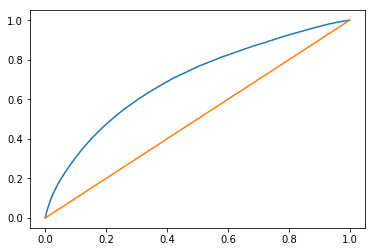

In [112]:
predicted_probs = predictions.select('Delayed', 'probability').toPandas()

y_true = predicted_probs['Delayed']
y_prob_predicted = predicted_probs['probability'].map(lambda vector: vector[1])

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob_predicted)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 10), np.linspace(0,1, 10))

Not bad, considering we have not performed any feature engineering at all!

### Further Reading

https://spark.apache.org/docs/2.2.0/ml-tuning.html

https://stackoverflow.com/questions/28569788/how-to-open-stream-zip-files-through-spark